## Automatic Segmentation of deep brain nuclei with priors

In this notebook a method for automatic segmentation on older patients deep nuclei using a prior from younger ones is described.

For each target nuclei, the **center of gravity** of the prior mask is computed. A box is constructed with a specific **side** (usually 10-12 voxel) centered on this value, in order to have a **local evaluation**

Coordinates of this box, together with scaled image gray values are the features that we're intereset in.

A KMeans algorithm is run with **n_cluster** (default=10) in order to find consistent region of images. 

The algorithm choose randomly **n_cluster** centroids and compute the euclidian distance of each point to the centroids.

$d(x_i,c)= |x_i-c|^2$

Each point will have **n_cluster** distances from each one of the centroids and it is associated the cluster of the closest centroid.
Now, for each cluster, the new centroids are computed as the mean coordinates of the points

$c_k'= \frac{1}{M} \sum_{i} x_i$ for i in cluster K

and the process is repeated until convergence

The cluster that contains the center of mass is selected as the target cluster, and used as output mask.
A connected component analysis in 3D looking for 26 nearest neighbors is conducted to keep the largest connected components and avoid fragmented masks. The final mask is a boolean 3D box.
The box is placed in a 3D zeros array with the same shape of the original image


In [33]:
from segmentation import *
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as opj
import tqdm
import pandas as pd

In [2]:
prior_path="priors_12younger_inMIITRAv2space"
data_path="data_15elder_inMIITRAv2space"

In [3]:
priors=glob.glob(opj(prior_path,"*.nii.gz"))
data=glob.glob(opj(data_path,"*.nii.gz"))

In [4]:
img_nifti=nib.load(data[0])
img=img_nifti.get_fdata()
prior=nib.load(priors[0]).get_fdata()

In [ ]:
for i,d in enumerate(data):
    
    d_name=d.split("/")[-1].split(".nii.gz")[0]
    
    print(f"Performing segmentation for {d_name} ({i}/{len(data)}")
    os.makedirs(opj("km_segmentations",d_name),exist_ok=True)
    img_nifti=nib.load(d)
    affine=img_nifti.affine
    img=img_nifti.get_fdata()
    for p in tqdm.tqdm(priors):
        
        p_name=p.split("/")[-1]

        prior=nib.load(p).get_fdata()
        seg=run_segmentation(img,prior,n_cluster=10,half_side=6)
        out=nib.Nifti1Image(seg,affine=affine)
        nib.save(out,opj("km_segmentations",d_name,p_name))

Performing segmentation for dtifit_d_S0_bfc_sub8_masked_2_MIITRA2 (0/15


100%|█████████████████████████████████████████| 120/120 [00:53<00:00,  2.23it/s]


Performing segmentation for dtifit_d_S0_bfc_sub18_masked_2_MIITRA2 (1/15


 22%|█████████                                 | 26/120 [00:11<00:42,  2.22it/s]

In [5]:
seg=run_segmentation(img,prior,n_cluster=10,half_side=6)

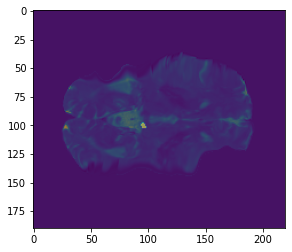

In [8]:
plt.imshow(img[:,:,91])
plt.imshow(prior[:,:,91],alpha=0.5)

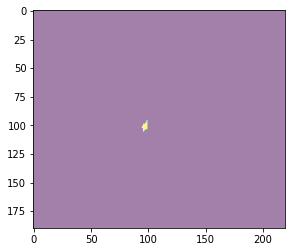

In [9]:
plt.imshow(seg[:,:,91],alpha=0.5)

In [19]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())## Evaluation

In [32]:
prior_names=os.listdir(prior_path)
d_name=d.split("/")[-1].split(".nii.gz")[0]

dice_dict={}
for p in tqdm.tqdm(prior_names):
    
    dice_dict[p]=[]
    
    for i,d in enumerate(data):
    
        d_name=d.split("/")[-1].split(".nii.gz")[0]
        ref_file=opj(prior_path,p)
        target_file=opj("km_segmentations",d_name,p)
        try:
            dice_score=dice(nib.load(target_file).get_fdata(),nib.load(ref_file).get_fdata())
            dice_dict[p].append(dice_score)
        except:
            print(f"file {target_file} or {ref_file} is not a nifti")
    
    # opj("km_segmentations",d_name

  0%|                                                   | 0/121 [00:00<?, ?it/s]/tmp/ipykernel_2064888/2134065819.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_2064888/2134065819.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
 16%|██████▌        

file km_segmentations/dtifit_d_S0_bfc_sub8_masked_2_MIITRA2/zList_nucleilabels_name.txt or priors_12younger_inMIITRAv2space/zList_nucleilabels_name.txt is not a nifti
file km_segmentations/dtifit_d_S0_bfc_sub18_masked_2_MIITRA2/zList_nucleilabels_name.txt or priors_12younger_inMIITRAv2space/zList_nucleilabels_name.txt is not a nifti
file km_segmentations/dtifit_d_S0_bfc_sub17_masked_2_MIITRA2/zList_nucleilabels_name.txt or priors_12younger_inMIITRAv2space/zList_nucleilabels_name.txt is not a nifti
file km_segmentations/dtifit_d_S0_bfc_sub3_masked_2_MIITRA2/zList_nucleilabels_name.txt or priors_12younger_inMIITRAv2space/zList_nucleilabels_name.txt is not a nifti
file km_segmentations/dtifit_d_S0_bfc_sub23_masked_2_MIITRA2/zList_nucleilabels_name.txt or priors_12younger_inMIITRAv2space/zList_nucleilabels_name.txt is not a nifti
file km_segmentations/dtifit_d_S0_bfc_sub7_masked_2_MIITRA2/zList_nucleilabels_name.txt or priors_12younger_inMIITRAv2space/zList_nucleilabels_name.txt is not a n

100%|█████████████████████████████████████████| 121/121 [08:58<00:00,  4.45s/it]


In [38]:
dice_dict={i:v for i,v in dice_dict.items() if len(v)}

In [40]:
df=pd.DataFrame.from_dict(dice_dict)
df

,s5_l10_2_MIITRA2.nii.gz,s5_r10_2_MIITRA2.nii.gz,s7_r10_2_MIITRA2.nii.gz,s4_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s12_l3_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s12_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s2_l2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s11_l10_2_MIITRA2.nii.gz,s1_r3_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s5_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,...,s10_l2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s12_l9_2_MIITRA2.nii.gz,s9_l1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s8_r1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s1_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s10_r10_2_MIITRA2.nii.gz,s2_l3_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s1_l1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s7_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s8_l1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz
0,0.219626,0.315789,0.093817,0.066667,0.173780,0.126050,0.138756,0.234114,0.245413,0.061856,...,0.071685,0.260465,0.000000,0.000000,0.097324,0.145695,0.267456,0.323529,0.076923,0.000000
1,0.071006,0.209524,0.192691,0.125313,0.174807,0.244565,0.233600,0.188088,0.357438,0.105263,...,0.290076,0.383562,0.329843,0.000000,0.284658,0.074928,0.153333,0.264766,0.188437,0.243902
2,0.263636,0.168116,0.053333,0.127273,0.262420,0.247475,0.213220,0.220096,0.411929,0.126374,...,0.288714,0.276730,0.322767,0.000000,0.267135,0.036364,0.250000,0.332724,0.188976,0.253968
3,0.261307,0.081395,0.102881,0.157480,0.298436,0.188450,0.253425,0.108808,0.281849,0.118033,...,0.267913,0.244275,0.339426,0.237918,0.195219,0.104987,0.246023,0.013575,0.169265,0.236111
4,0.121212,0.615385,0.315271,0.101695,0.230539,0.291667,0.140598,0.459627,0.331878,0.109589,...,0.163569,0.101408,0.000000,0.000000,0.234273,0.077844,0.182781,0.393443,0.159780,0.000000
5,0.104762,0.169611,0.053030,0.172775,0.227001,0.250696,0.258407,0.080569,0.316611,0.156863,...,0.353211,0.164835,0.000000,0.190751,0.244361,0.053254,0.172093,0.380789,0.195556,0.000000
6,0.062651,0.166234,0.061920,0.157044,0.405797,0.204489,0.252174,0.165289,0.385281,0.112045,...,0.242718,0.280899,0.440318,0.000000,0.275261,0.051282,0.195996,0.256619,0.191617,0.290780
7,0.330275,0.260274,0.069204,0.122137,0.172808,0.218289,0.220952,0.345679,0.215228,0.107256,...,0.288557,0.215686,0.000000,0.436364,0.253906,0.036530,0.199115,0.524946,0.177874,0.000000
8,0.193548,0.135135,0.072072,0.118033,0.188352,0.129794,0.150713,0.133333,0.285396,0.087336,...,0.213873,0.238683,0.408284,0.000000,0.148438,0.050179,0.183746,0.000000,0.144772,0.329218
9,0.089776,0.053908,0.000000,0.083650,0.284224,0.260000,0.138889,0.064665,0.283146,0.085561,...,0.242623,0.288000,0.422764,0.248963,0.262156,0.145161,0.245734,0.363289,0.102719,0.291971


In [42]:
df.to_csv("km_segmentations.csv",index=True)

In [43]:
df.describe()

,s5_l10_2_MIITRA2.nii.gz,s5_r10_2_MIITRA2.nii.gz,s7_r10_2_MIITRA2.nii.gz,s4_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s12_l3_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s12_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s2_l2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s11_l10_2_MIITRA2.nii.gz,s1_r3_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s5_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,...,s10_l2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s12_l9_2_MIITRA2.nii.gz,s9_l1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s8_r1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s1_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s10_r10_2_MIITRA2.nii.gz,s2_l3_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s1_l1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s7_r2_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz,s8_l1_Seg_4cl_S0_WBednoCSF_2_MIITRA2.nii.gz
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.204818,0.211311,0.095155,0.127934,0.261729,0.203468,0.209472,0.212102,0.288804,0.108684,...,0.230429,0.289511,0.180257,0.100541,0.212219,0.063214,0.196515,0.245317,0.164801,0.130301
std,0.106915,0.136147,0.075014,0.038001,0.074233,0.056591,0.048760,0.121445,0.085266,0.028463,...,0.088984,0.102758,0.202502,0.139275,0.062776,0.039446,0.041633,0.188734,0.051287,0.146009
min,0.062651,0.053908,0.000000,0.066667,0.172808,0.100946,0.138756,0.044776,0.057931,0.051064,...,0.071685,0.101408,0.000000,0.000000,0.089796,0.027523,0.140391,0.000000,0.073879,0.000000
25%,0.112865,0.150684,0.056592,0.103479,0.207677,0.168060,0.158442,0.121071,0.262196,0.096300,...,0.188721,0.241479,0.000000,0.000000,0.186057,0.036447,0.166273,0.006787,0.134485,0.000000
50%,0.193548,0.180556,0.072072,0.125313,0.259887,0.204489,0.220952,0.188088,0.285396,0.109589,...,0.242623,0.276730,0.000000,0.000000,0.234273,0.050179,0.183746,0.323529,0.177874,0.000000
75%,0.296956,0.247292,0.108475,0.157262,0.291330,0.249086,0.247075,0.316491,0.337524,0.127358,...,0.288636,0.348644,0.373855,0.198095,0.263837,0.076386,0.238506,0.383997,0.193586,0.272374
max,0.369048,0.615385,0.315271,0.192593,0.405797,0.291667,0.276083,0.459627,0.411929,0.156863,...,0.368932,0.503311,0.440449,0.436364,0.284658,0.145695,0.267456,0.524946,0.245243,0.329218


In [46]:
(df==0).sum().sum()

157